In [1]:
#Testing performance by variating learning rules and cost functions
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
#The data corresponds to a matrix in which each row vector corresponds to a 20x20 spin configuration
#at a certain temperature. The number of rows of this data matrix indicates the number of conficurations
#and the number of columns is 20**2

#the data was generated using the code found in https://github.com/tarod13/Monograph

#configurations with mode=0, the initial state is a random  matrix 
with open('spins_COP_4.p', 'rb') as f:
    data = pickle.load(f)
with open('temperatures_COP_4.p', 'rb') as f:
    temp = pickle.load(f)

In [3]:
n_config=np.shape(data)[0]
n_spins=len(data[0,:])

print(n_config)
print(n_spins)

M=[] #stores the total (scaled) magnetization of each configuration in terms of temperature

#calculates magnetization for each configuration
for i in range(0,n_config):
    m=0
    m=np.sum(data[i,:])/n_spins    
    M.append(m)

1024
400


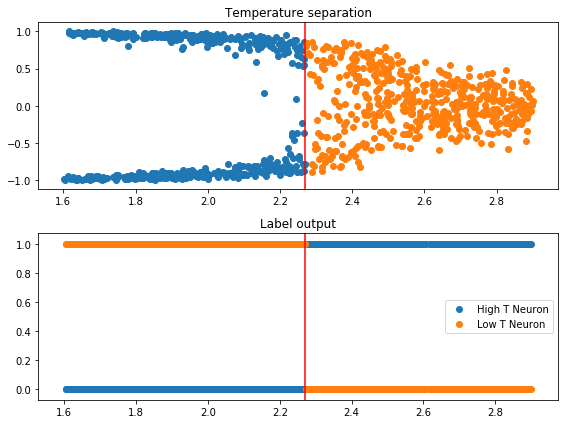

In [4]:
#Cambiando las labels a temperatura. La idea es que todo antes de la temperatura crítica sea por ejemplo [1,0] y
#todo por encima [0,1]. De nuevo usamos newT, newD y newM

#represents two output neurons [1,0] means ober critical T and [0,1] means under critical T
labels_T=np.zeros((len(temp),2)) 

#asigns temperature with respect to critical temperature
def T_labels(Ma,Te,crit,labels):
    T=np.array(Te)
    M = np.array(Ma)
    ii= T< crit
    jj = T>=crit
    #under Tc
    labels[ii,:]=[0,1]
    labels[jj,:]=[1,0]
    return T[ii], M[ii], T[jj], M[jj]
    
Tc=2.2691853

T_small, M_small, T_big, M_big = T_labels(M, temp, Tc,labels_T)

#plt.scatter(T_less,M_less)
#plt.scatter(T_big, M_big)
#plt.axvline(x=Tc, color='red')

fig, subp=plt.subplots(2,1,figsize=(8,6)) #crea 2 subplots en una columna
#fig es la entidad figura y subp es un array que en cada posicion guarda el subplot
#subp se puede manipular como un array para modificar individualmente los subplots
subp[0].scatter(T_small,M_small)
subp[0].scatter(T_big, M_big)
subp[0].set_title('Temperature separation')
subp[0].axvline(x=Tc, color='red')
subp[1].scatter(temp,labels_T[:,0], label='High T Neuron')
subp[1].scatter(temp,labels_T[:,1], label='Low T Neuron')
subp[1].set_title('Label output')
subp[1].legend()
subp[1].axvline(x=Tc, color='red')
subp
fig.tight_layout() #ajusta la distancia entre plots


In [5]:
#initializes weights
def weig(shape):
    first= tf.random_normal(shape,stddev=0.2)
    return tf.Variable(first)

#initializes bias
def bi(shape):
    first = tf.constant(np.random.rand(), shape=shape)
    return tf.Variable(first)

#defines the output function of each neuron in the layer
def layers(x, W,b):
  return tf.nn.sigmoid(tf.matmul(x, W)+b)



In [6]:
#WITH REGULARIZATION
#IT takes a like 40 minutes to run 60k epochs and we obtain a train_accuracy of 0.96 and eval_acc of 0.93
#very, very good


n_labels=2 #there will be one output neuron for each label
hidden=200 #number of hidden units
size=n_spins #system size


#Now we create the model with the input vector and teacher vector. This is the input layer
x = tf.placeholder("float", shape=[None, size])
y = tf.placeholder("float", shape=[None, n_labels]) #teacher vector = label


#defining the hidden layer
W_1 = weig([size,hidden])
b_1 = bi([hidden])
lay_1 = layers(x, W_1,b_1)
#Output layer
W_2 = weig([hidden,n_labels])
b_2 = bi([n_labels])
y_hat=layers(lay_1, W_2,b_2) #our predicted value

#Defining the cost function
error = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat)

#adds an l2 regularization term to with a beta value
beta=0.01
error = tf.reduce_mean(error + beta *( tf.nn.l2_loss(W_1)+tf.nn.l2_loss(W_2)))

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = tf.train.AdamOptimizer(0.001)
train = optimizer.minimize(error)


#predictions
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))




In [7]:
saver2= tf.train.Saver()

In [8]:
#Variable outputs used to access data from the session tensors
out=np.zeros(shape=(len(temp),n_labels))
outav=np.zeros(shape=(len(temp)))
outac = np.zeros(shape=(len(temp)))
evolve_acc = []

#starting a session 
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    
    epochs = 70000
    #training cycle
    
    for i in range(epochs):
        train_accuracy = sess.run(accuracy,feed_dict={ x:data, y: labels_T})      
        sess.run(train,feed_dict={x:data, y:labels_T})#feeding data to the place holders 
        #stops training when accuracy crosses a certain threshold
        if i%1000 == 0:
            evolve_acc.append(train_accuracy)
            print ("step %d, training accuracy %g"%(i, train_accuracy))
        if(train_accuracy>=0.96):
            print(train_accuracy)
            print(i)
            break;
    print("Accuracy:", train_accuracy)

    
    #now let's try checking the neuron outputs for each temperature
    out=(sess.run(y_hat,feed_dict={x:data, y:labels_T}))
    for i in range(len(temp)):
        res=sess.run(y_hat,feed_dict={x: data, y: labels_T})
        
    outav=res #neuron outputs
    
    saver2.save(sess, 'ising2.ckpt')

step 0, training accuracy 0.568359
step 1000, training accuracy 0.702148
step 2000, training accuracy 0.706055
step 3000, training accuracy 0.706055
step 4000, training accuracy 0.952148
step 5000, training accuracy 0.952148
step 6000, training accuracy 0.952148
step 7000, training accuracy 0.953125
step 8000, training accuracy 0.953125
step 9000, training accuracy 0.953125
step 10000, training accuracy 0.953125
step 11000, training accuracy 0.951172
step 12000, training accuracy 0.952148
step 13000, training accuracy 0.953125
step 14000, training accuracy 0.953125
step 15000, training accuracy 0.953125
step 16000, training accuracy 0.953125
step 17000, training accuracy 0.952148
step 18000, training accuracy 0.953125
step 19000, training accuracy 0.953125
step 20000, training accuracy 0.952148
step 21000, training accuracy 0.953125
step 22000, training accuracy 0.953125
step 23000, training accuracy 0.953125
step 24000, training accuracy 0.952148
step 25000, training accuracy 0.953125

In [9]:
#Loads test data
with open('spins_COP_test.p', 'rb') as f:
    test_D = pickle.load(f)
with open('temperatures_COP_test.p', 'rb') as f:
    test_T = pickle.load(f)

In [10]:
test_config=np.shape(test_D)[0]
test_spins=len(test_D[0,:])

print(test_config)
print(test_spins)

test_M=[] #stores the total (scaled) magnetization of each configuration in terms of temperature

#calculates magnetization for each configuration
for i in range(0,n_config):
    m=0
    m=np.sum(test_D[i,:])/n_spins  
    test_M.append(m)

#represents two output neurons [1,0] means ober critical T and [0,1] means under critical T
labels_test=np.zeros((len(test_T),2)) 

T_small2, M_small2, T_big2, M_big2 = T_labels(test_M, test_T, Tc,labels_test)

1024
400


In [11]:
#evaluates the trained network with the new unlabeled data
with tf.Session() as sess:
    #restores the model
    saver2.restore(sess, 'ising2.ckpt')
    for i in range(len(test_T)):
        output= sess.run(y_hat,feed_dict={x:test_D})
    print('evaluation accuracy=',  accuracy.eval({ x: test_D, y:labels_test}))

    h_w= sess.run(W_1,feed_dict={x:test_D})




INFO:tensorflow:Restoring parameters from ising2.ckpt
evaluation accuracy= 0.9355469


(400, 200)


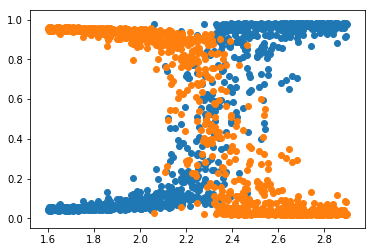

In [12]:
print(np.shape(h_w))
plt.scatter(test_T, output[:,0])
plt.scatter(test_T, output[:,1])
plt.show()

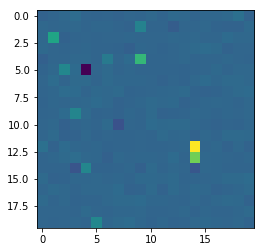

In [20]:
h_w1= h_w[:,0].reshape(-1,20)
sites=np.linspace(1,400,400)
plt.imshow(h_w1)

In [16]:
weigth_out=pd.DataFrame(h_w)
weigth_out.to_csv('W4.csv')

In [45]:
#Funny thing is that trainig acc varies but evaluation acc stays pretty much the same